In [3]:
from sklearn.metrics.pairwise import haversine_distances
points_in_radians = geo[['latitude','longitude']].apply(np.radians).values
distances_in_km = haversine_distances(points_in_radians) * 6371

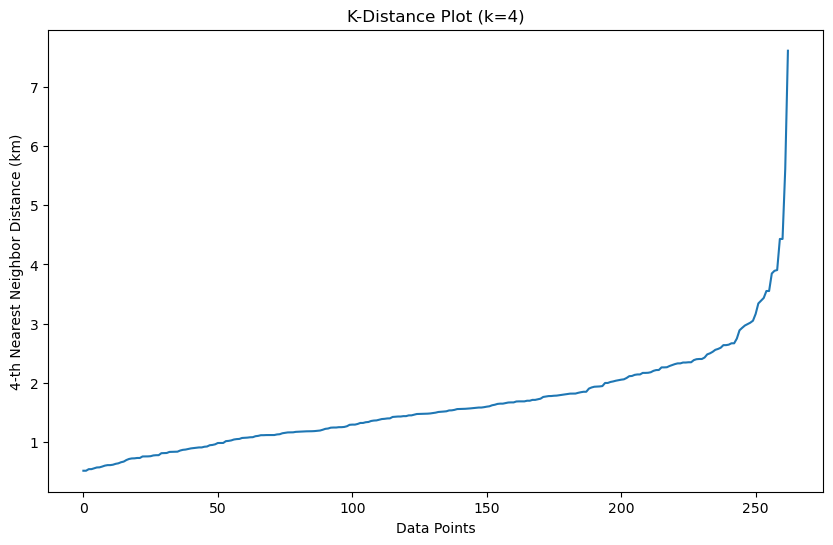

In [49]:
from sklearn.neighbors import NearestNeighbors

k = 4
# Fit the model using the precomputed distance matrix
neighbors = NearestNeighbors(n_neighbors=k, metric='precomputed')
neighbors.fit(distances_in_km)

# Get the k-nearest neighbors
distances, indices = neighbors.kneighbors(distances_in_km)

# Now, 'distances' and 'indices' will give you the k-nearest neighbors based on the precomputed distances
# Sort the distances
distances_km = np.sort(distances_km, axis=0)

# Plot the k-distance graph (in kilometers)
plt.figure(figsize=(10, 6))
plt.plot(distances_km)
plt.title(f'K-Distance Plot (k={k})')
plt.xlabel('Data Points')
plt.ylabel(f'{k}-th Nearest Neighbor Distance (km)')
plt.show()

In [4]:
start_date = '2024-09-02'
end_date = '2024-09-09'
first = trips[(trips['pickup_datetime'] >= start_date) & (trips['pickup_datetime'] < end_date)]
first.reset_index(drop=True, inplace=True)
zone_weights = first['DOLocationID'].value_counts().reset_index()
zone_weights.columns = ['LocationID', 'weight']

In [6]:
print(geo.shape)
print(zone_weights.shape)

(263, 9)
(261, 2)


In [8]:
missing_location_ids = geo[~geo['LocationID'].isin(zone_weights['LocationID'])]
missing_location_ids

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude,geometry
102,103,0.014306,0.000006,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,-74.045288,40.689860,"POLYGON ((-74.04389 40.69018, -74.04351 40.689..."
103,104,0.021221,0.000012,Governor's Island/Ellis Island/Liberty Island,104,Manhattan,-74.040771,40.698769,"POLYGON ((-74.03995 40.70089, -74.03945 40.700..."
198,199,0.077809,0.000289,Rikers Island,199,Bronx,-73.882658,40.791133,"POLYGON ((-73.88885 40.79871, -73.8886 40.7986..."


In [9]:
geo_first = pd.merge(geo, zone_weights, on='LocationID', how='left')
geo_first['weight'].fillna(0, inplace=True)
geo_first['log_weight'] = np.log1p(geo_first['weight'])

In [10]:
from sklearn.metrics.pairwise import euclidean_distances
added_km_per_rating_gap = 1
rating_distances = euclidean_distances(geo_first[['log_weight']].values) * added_km_per_rating_gap 
rating_std = np.std(rating_distances)

In [11]:
location_std = np.std(distances_in_km)
print(rating_std)
print(location_std)

1.7851637525228565
8.709431732088492


In [12]:
added_km_per_rating_gap = location_std / rating_std
added_km_per_rating_gap

4.8787858927675485

In [13]:
rating_distances = euclidean_distances(geo_first[['log_weight']].values) * 4.9

In [14]:
distance_matrix = rating_distances + distances_in_km

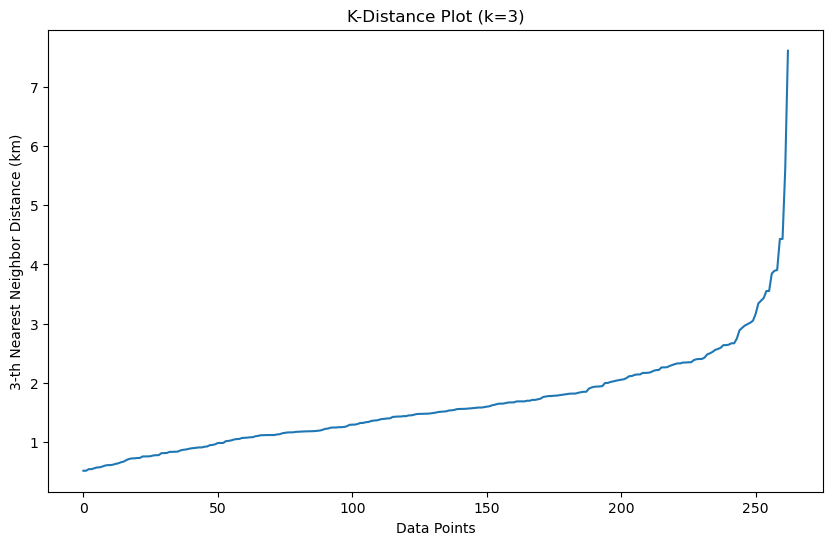

In [27]:
from sklearn.neighbors import NearestNeighbors

# Function to calculate the Haversine distance between two lat/lon points in km
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    R = 6371  # Radius of Earth in kilometers
    return R * c

# Compute nearest neighbors
k = db.min_samples  # Or set k to another value if needed
k = 3
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(geo_first[['latitude', 'longitude']])
distances, indices = neighbors_fit.kneighbors(geo_first[['latitude', 'longitude']])

# Convert the distances from degrees to kilometers using the Haversine formula
distances_km = np.array([haversine(geo_first.iloc[i]['latitude'], geo_first.iloc[i]['longitude'],
                                   geo_first.iloc[indices[i, k-1]]['latitude'], geo_first.iloc[indices[i, k-1]]['longitude'])
                         for i in range(len(geo_first))])

# Sort the distances
distances_km = np.sort(distances_km, axis=0)

# Plot the k-distance graph (in kilometers)
plt.figure(figsize=(10, 6))
plt.plot(distances_km)
plt.title(f'K-Distance Plot (k={k})')
plt.xlabel('Data Points')
plt.ylabel(f'{k}-th Nearest Neighbor Distance (km)')
plt.show()

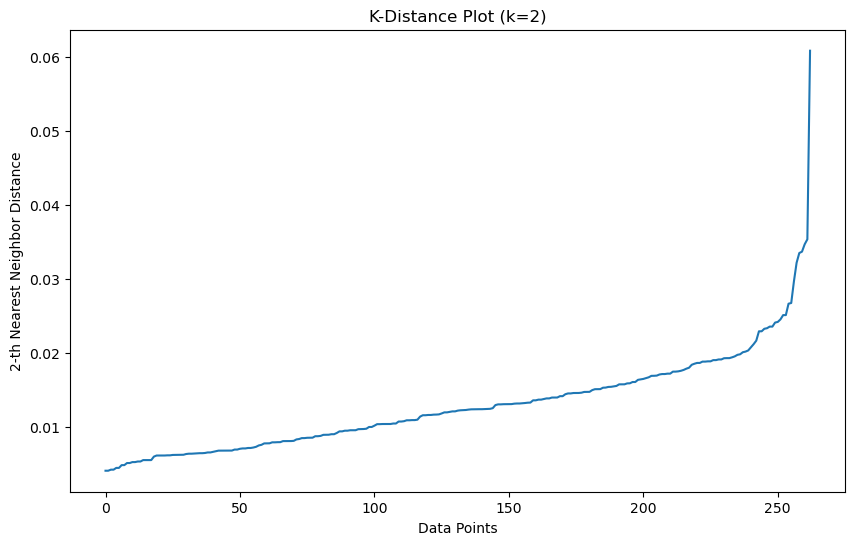

In [18]:
from sklearn.neighbors import NearestNeighbors

k = db.min_samples

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(geo_first[['latitude', 'longitude']])
distances, indices = neighbors_fit.kneighbors(geo_first[['latitude', 'longitude']])

distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title(f'K-Distance Plot (k={k})')
plt.xlabel('Data Points')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.show()

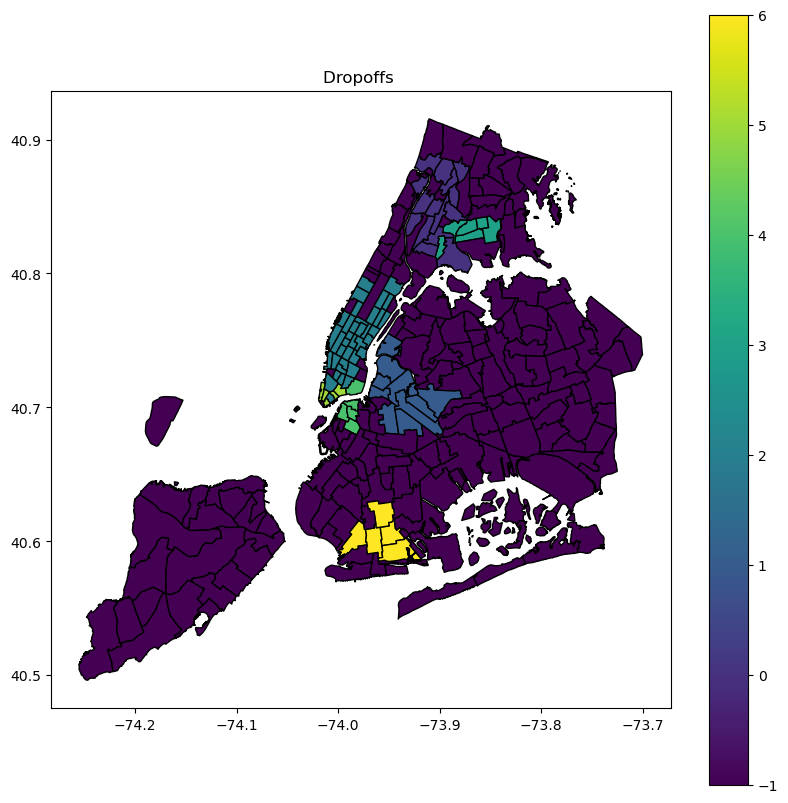

In [63]:
from sklearn.cluster import DBSCAN

db = DBSCAN(metric='precomputed', eps=2.75, min_samples=5)
db.fit(distance_matrix)
geo_first['cluster'] = db.labels_
geo_first.plot(column='cluster', figsize=(10, 10), edgecolor='black', legend=True)
plt.title("Dropoffs ")
plt.show()

C:\Users\r-cet\anaconda3\envs\DSML_env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


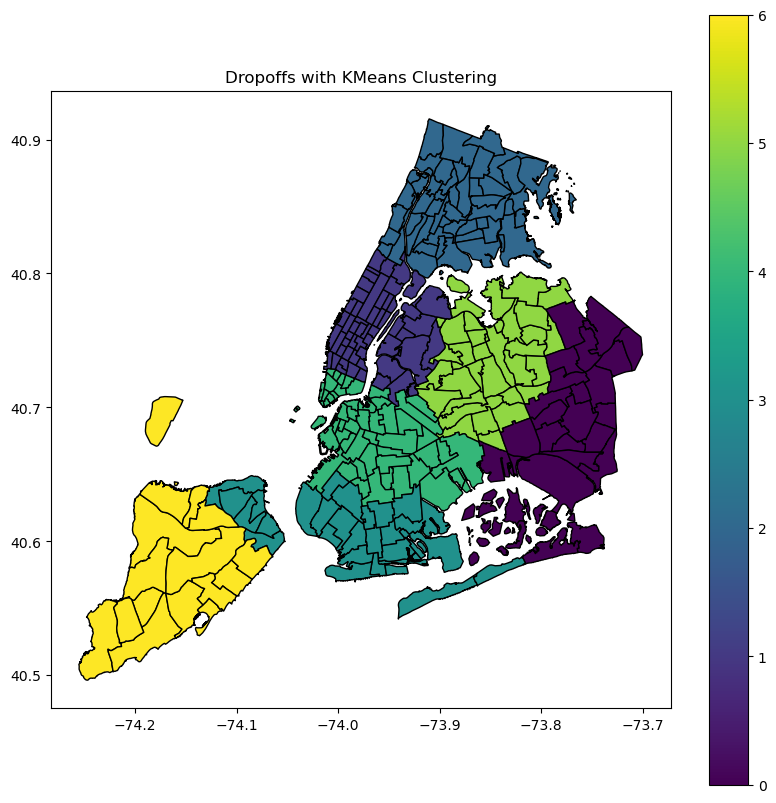

In [65]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(distances_in_km)

geo_first['cluster'] = kmeans.labels_

geo_first.plot(column='cluster', figsize=(10, 10), edgecolor='black', legend=True)
plt.title("Dropoffs with KMeans Clustering")
plt.show()

C:\Users\r-cet\anaconda3\envs\DSML_env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


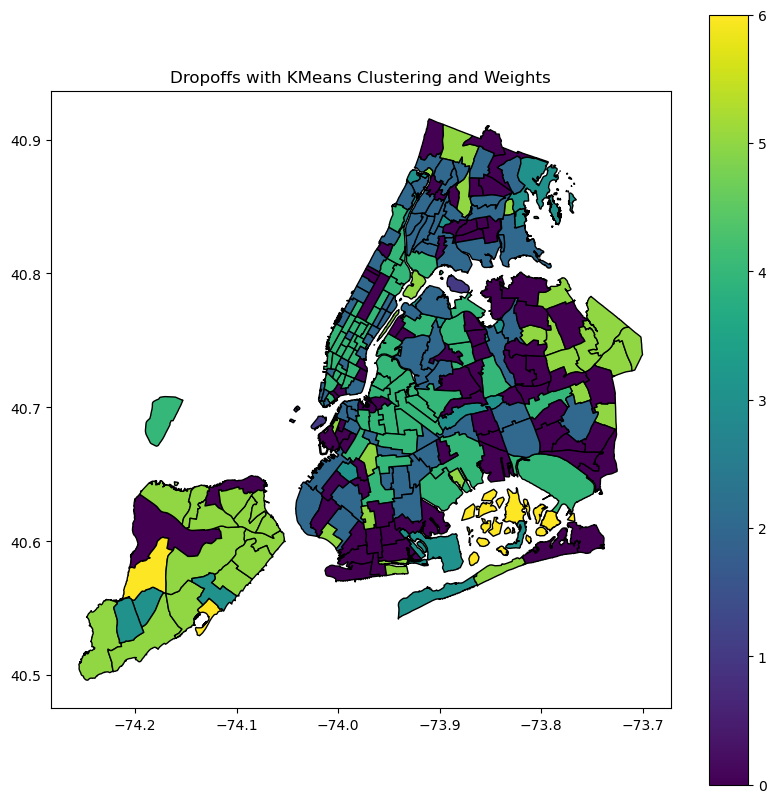

In [72]:
features = geo_first[['latitude', 'longitude', 'log_weight']].values

# Fit KMeans with the precomputed distance matrix
kmeans = KMeans(n_clusters=7, random_state=42)  # Adjust clusters as needed
kmeans.fit(features)

# Assign cluster labels
geo_first['cluster'] = kmeans.labels_

# Plot the clusters
geo_first.plot(column='cluster', figsize=(10, 10), edgecolor='black', legend=True)
plt.title("Dropoffs with KMeans Clustering and Weights")
plt.show()


In [74]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
geo_first['scaled_weight'] = scaler.fit_transform(geo_first[['weight']])

In [75]:
k_means_featues = geo_first[['latitude', 'longitude', 'scaled_weight']]

In [77]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=42)
geo_first['k_means_cluster'] = kmeans.fit_predict(k_means_featues)

C:\Users\r-cet\anaconda3\envs\DSML_env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


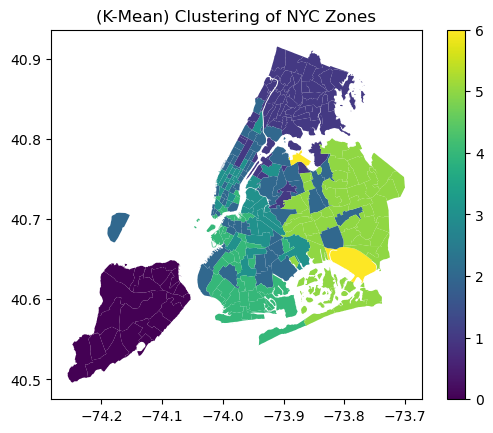

In [79]:
geo_first.plot(column='k_means_cluster', cmap='viridis', legend=True)
plt.title("(K-Mean) Clustering of NYC Zones")
plt.show()

In [80]:
zone_weights4 = trips['DOLocationID'].value_counts().reset_index()
zone_weights4.columns = ['LocationID', 'weight4']

In [81]:
geo4 = pd.merge(geo, zone_weights4, on='LocationID', how='left')
geo4['weight4'].fillna(0, inplace=True)

In [82]:
std = np.std(geo4['weight4'])
std

58033.558929684004

In [84]:
geo4['log_weight4'] = np.log1p(geo4['weight4'])
std = np.std(geo4['log_weight4'])
std

1.7468024397725068

In [85]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
geo4['scaled_weight4'] = scaler.fit_transform(geo4[['weight4']])
std = np.std(geo4['scaled_weight4'])
std

0.14250526456196136

In [94]:
k_means_featues = geo4[['latitude', 'longitude', 'log_weight4']]
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=42)
geo4['k_means_cluster'] = kmeans.fit_predict(k_means_featues)

C:\Users\r-cet\anaconda3\envs\DSML_env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


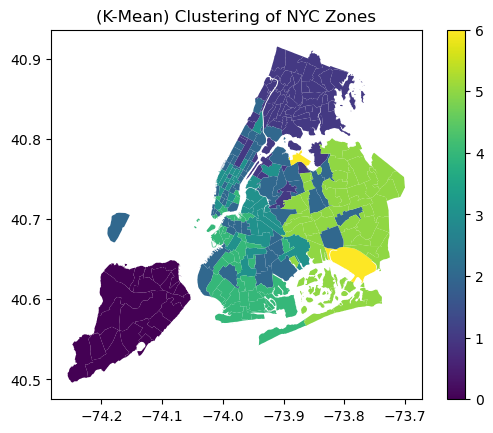

In [95]:
geo_first.plot(column='k_means_cluster', cmap='viridis', legend=True)
plt.title("(K-Mean) Clustering of NYC Zones")
plt.show()

C:\Users\r-cet\anaconda3\envs\DSML_env\Lib\site-packages\sklearn\neighbors\_kde.py:270: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


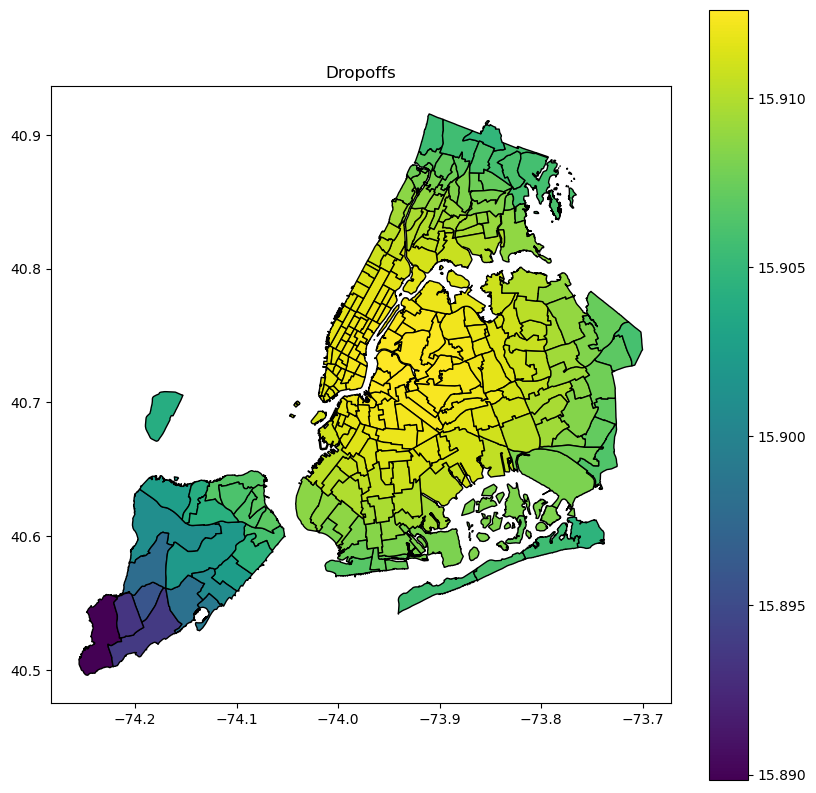

In [96]:
weights = geo4['log_weight4']
from sklearn.neighbors import KernelDensity
coords = np.radians(geo[['latitude', 'longitude']].values)  # Convert to radians
kde = KernelDensity(bandwidth=0.1, metric='haversine').fit(coords, sample_weight=weights)
geo_first['density'] = np.exp(kde.score_samples(coords))
geo_first.plot(column='density', figsize=(10, 10), edgecolor='black', legend=True)
plt.title("Dropoffs")
plt.show()

C:\Users\r-cet\anaconda3\envs\DSML_env\Lib\site-packages\sklearn\neighbors\_kde.py:270: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


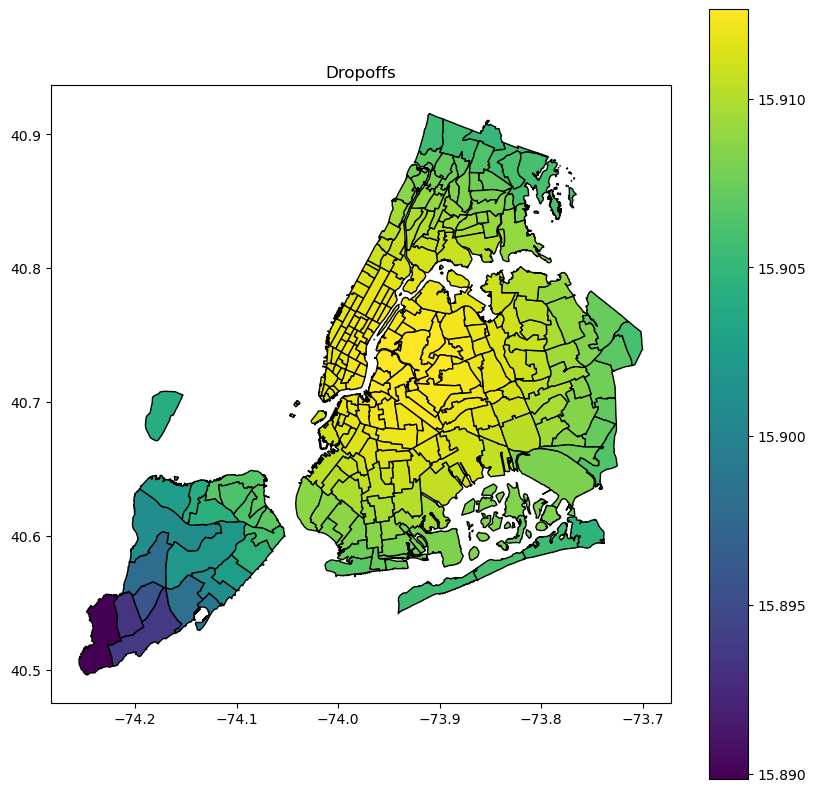

In [99]:
weights = geo_first['log_weight']
from sklearn.neighbors import KernelDensity
coords = np.radians(geo[['latitude', 'longitude']].values)  # Convert to radians
kde = KernelDensity(bandwidth=0.1, metric='haversine').fit(coords, sample_weight=weights)
geo_first['density'] = np.exp(kde.score_samples(coords))
geo_first.plot(column='density', figsize=(10, 10), edgecolor='black', legend=True)
plt.title("Dropoffs")
plt.show()

**AGGregation**

In [6]:
trips = trips[~trips['DOLocationID'].isin([265]) & ~trips['PULocationID'].isin([265])]

In [104]:
trips['do_hour'] = trips['dropoff_datetime'].dt.hour
trips['do_hour_group'] = trips['do_hour'].apply(lambda x: f"_{x // 3 * 3}_{x // 3 * 3 + 2}")
DO = trips.groupby(['do_hour_group', 'DOLocationID']).size().reset_index(name='do_demand')
trips['pu_hour'] = trips['pickup_datetime'].dt.hour
trips['pu_hour_group'] = trips['pu_hour'].apply(lambda x: f"_{x // 3 * 3}_{x // 3 * 3 + 2}")
PU = trips.groupby(['pu_hour_group', 'PULocationID']).size().reset_index(name='pu_demand')

In [112]:
all_location_ids = geo['LocationID'].unique()

DO = DO.set_index(['do_hour_group', 'DOLocationID']).reindex(
    pd.MultiIndex.from_product([DO['do_hour_group'].unique(), all_location_ids], names=['do_hour_group', 'DOLocationID']),
    fill_value=0
).reset_index()

PU = PU.set_index(['pu_hour_group', 'PULocationID']).reindex(
    pd.MultiIndex.from_product([PU['pu_hour_group'].unique(), all_location_ids], names=['pu_hour_group', 'PULocationID']),
    fill_value=0
).reset_index()

In [113]:
print(PU.shape)
print(DO.shape)
print(geo.shape)

(2104, 3)
(2104, 3)
(263, 9)


In [114]:
geo.info()
PU.info()
DO.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   longitude   263 non-null    float64 
 7   latitude    263 non-null    float64 
 8   geometry    263 non-null    geometry
dtypes: float64(4), geometry(1), int32(2), object(2)
memory usage: 16.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2104 entries, 0 to 2103
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   pu_hour_group  2104 non-null   object
 1   PULocationID   2104 non-null   int32 
 2   pu_demand      2104 non-null   int64 
dtypes: int32(1), int64(1), o

In [115]:
PU = PU.merge(
    geo[['LocationID', 'latitude', 'longitude']],
    left_on='PULocationID',
    right_on='LocationID',
    how='left'
).drop(columns=['LocationID'])

DO = DO.merge(
    geo[['LocationID', 'latitude', 'longitude']],
    left_on='DOLocationID',
    right_on='LocationID',
    how='left'
).drop(columns=['LocationID'])

In [116]:
cs = pd.read_csv('cs.csv')
cs_nyc = gpd.read_file("cs_nyc.shp")
cs.info()
cs_nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1152 non-null   int64  
 1   STATION NAME     1152 non-null   object 
 2   TYPE OF CHARGER  1152 non-null   object 
 3   NO. OF PLUGS     1152 non-null   int64  
 4   BOROUGH          1152 non-null   object 
 5   PUBLIC CHARGER?  24 non-null     object 
 6   LATITUDE         1152 non-null   float64
 7   LONGITUDE        1152 non-null   float64
 8   geometry         1152 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 81.1+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATION NA  1152 non-null   object  
 1   TYPE OF CH  1152 non-null   object  
 2   NO. OF PLU  1152 non-null   int64   


In [117]:
cs_ = cs[['LATITUDE', 'LONGITUDE', 'TYPE OF CHARGER', 'NO. OF PLUGS']]

In [119]:
cs_.info()
print(cs['TYPE OF CHARGER'].values)
print(cs['NO. OF PLUGS'].values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   LATITUDE         1152 non-null   float64
 1   LONGITUDE        1152 non-null   float64
 2   TYPE OF CHARGER  1152 non-null   object 
 3   NO. OF PLUGS     1152 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 36.1+ KB
['Level 3 Fast Charger' 'Level 3 Fast Charger' 'Level 2 Charger' ...
 'Level 2 Charger' 'Level 2 Charger' 'Level 2 Charger']
[1 1 1 ... 1 1 1]


In [120]:
PU.info()
DO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2104 entries, 0 to 2103
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pu_hour_group  2104 non-null   object 
 1   PULocationID   2104 non-null   int32  
 2   pu_demand      2104 non-null   int64  
 3   latitude       2104 non-null   float64
 4   longitude      2104 non-null   float64
dtypes: float64(2), int32(1), int64(1), object(1)
memory usage: 74.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2104 entries, 0 to 2103
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   do_hour_group  2104 non-null   object 
 1   DOLocationID   2104 non-null   int32  
 2   do_demand      2104 non-null   int64  
 3   latitude       2104 non-null   float64
 4   longitude      2104 non-null   float64
dtypes: float64(2), int32(1), int64(1), object(1)
memory usage: 74.1+ KB


In [121]:
# Merge PU and DO on LocationID and hour groups
hotspots = PU.merge(
    DO,
    left_on=['PULocationID', 'pu_hour_group'],
    right_on=['DOLocationID', 'do_hour_group'],
    how='outer',
    suffixes=('_pu', '_do')
)

# Fill NaN demand values with 0 for missing locations
hotspots['pu_demand'] = hotspots['pu_demand'].fillna(0)
hotspots['do_demand'] = hotspots['do_demand'].fillna(0)

# Calculate total demand per zone
hotspots['total_demand'] = hotspots['pu_demand'] + hotspots['do_demand']

# Aggregate demand per LocationID
hotspots_summary = hotspots.groupby('PULocationID', as_index=False).agg(
    total_demand=('total_demand', 'sum'),
    latitude=('latitude_pu', 'first'),
    longitude=('longitude_pu', 'first')
)

# Rename for clarity
hotspots_summary.rename(columns={'PULocationID': 'LocationID'}, inplace=True)

# Sort by demand (optional for visualization)
hotspots_summary = hotspots_summary.sort_values(by='total_demand', ascending=False)

hotspots_summary.head()

,LocationID,total_demand,latitude,longitude
137,138,740509,40.774376,-73.873629
131,132,666503,40.646985,-73.786533
60,61,457297,40.674469,-73.939287
78,79,422066,40.727620,-73.985937
67,68,392916,40.748428,-73.999917


In [123]:
from geopy.distance import geodesic

# Radius for coverage (in kilometers)
coverage_radius = 1.0

# Function to calculate distance between two coordinates
def calculate_distance(row, stations):
    hotspot_coords = (row['latitude'], row['longitude'])
    distances = stations.apply(
        lambda x: geodesic(hotspot_coords, (x['LATITUDE'], x['LONGITUDE'])).km,
        axis=1
    )
    return distances.min()  # Return the closest station distance

# Calculate the minimum distance to a charging station for each hotspot
hotspots_summary['min_distance_to_station'] = hotspots_summary.apply(
    calculate_distance,
    stations=cs_,  # Charging station DataFrame
    axis=1
)

# Identify hotspots outside the coverage radius
hotspots_summary['needs_station'] = hotspots_summary['min_distance_to_station'] > coverage_radius

# View the updated summary
hotspots_summary[['LocationID', 'total_demand', 'min_distance_to_station', 'needs_station']].head()

,LocationID,total_demand,min_distance_to_station,needs_station
137,138,740509,1.808324,True
131,132,666503,1.693980,True
60,61,457297,0.668480,False
78,79,422066,0.715390,False
67,68,392916,0.551346,False


In [133]:
# Define capacity for each charger type (adjust these based on data or assumptions)
charger_capacity = {
    'Level 2 Charger': 10,   # Maximum demand a Level 2 charger can handle
    'Level 3 Fast Charger': 50  # Maximum demand a Level 3 charger can handle
}

# Function to calculate remaining capacity of a station
def calculate_remaining_capacity(station):
    capacity = charger_capacity.get(station['TYPE OF CHARGER'], 0) * station['NO. OF PLUGS']
    return capacity

# Assign remaining capacity to each charging station
cs_['remaining_capacity'] = cs_.apply(calculate_remaining_capacity, axis=1)

# Process uncovered hotspots
def process_hotspot(hotspot, stations):
    hotspot_coords = (hotspot['latitude'], hotspot['longitude'])
    hotspot_demand = hotspot['total_demand']

    # Check nearby stations
    stations['distance_to_hotspot'] = stations.apply(
        lambda x: geodesic(hotspot_coords, (x['LATITUDE'], x['LONGITUDE'])).km,
        axis=1
    )
    nearby_stations = cs_[cs_['distance_to_hotspot'] <= coverage_radius]

    # Expansion: Check if any nearby station has enough capacity
    for _, station in nearby_stations.iterrows():
        if cs_['remaining_capacity'] >= hotspot_demand:
            # Update station capacity
            cs_['remaining_capacity'] -= hotspot_demand
            return f"Expand station at ({cs_['LATITUDE']}, {cs_['LONGITUDE']})"

    # If no station can handle demand, suggest a new placement
    return f"Build new station near ({hotspot['latitude']}, {hotspot['longitude']})"

# Apply the decision logic to uncovered hotspots
hotspots_summary['decision'] = hotspots_summary.apply(
    lambda x: process_hotspot(x, cs_) if x['needs_station'] else "Covered",
    axis=1
)

# View the final output
hotspots_summary[['LocationID', 'total_demand', 'min_distance_to_station', 'decision']].head()

C:\Users\r-cet\AppData\Local\Temp\ipykernel_14188\2244727349.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs_['remaining_capacity'] = cs_.apply(calculate_remaining_capacity, axis=1)


,LocationID,total_demand,min_distance_to_station,decision
137,138,740509,1.808324,"Build new station near (40.77437570593248, -73..."
131,132,666503,1.693980,"Build new station near (40.646984892395146, -7..."
60,61,457297,0.668480,Covered
78,79,422066,0.715390,Covered
67,68,392916,0.551346,Covered


In [135]:
hotspots_summary[hotspots_summary['decision'] != 'Covered']

,LocationID,total_demand,latitude,longitude,min_distance_to_station,needs_station,decision
137,138,740509,40.774376,-73.873629,1.808324,True,"Build new station near (40.77437570593248, -73..."
131,132,666503,40.646985,-73.786533,1.693980,True,"Build new station near (40.646984892395146, -7..."
248,249,298862,40.734576,-74.002875,1.145413,True,"Build new station near (40.73457600733177, -74..."
88,89,280772,40.637900,-73.960968,1.507167,True,"Build new station near (40.63790012347376, -73..."
38,39,246205,40.638037,-73.899735,1.128572,True,"Build new station near (40.63803713911706, -73..."
...,...,...,...,...,...,...,...
109,110,100,40.545780,-74.128342,1.248028,True,"Build new station near (40.54578031659563, -74..."
1,2,87,40.616745,-73.831299,3.899693,True,"Build new station near (40.61674529165981, -73..."
104,105,14,40.688784,-74.019073,1.265282,True,"Build new station near (40.68878423861296, -74..."
103,104,2,40.698769,-74.040771,2.231233,True,"Build new station near (40.698768673626134, -7..."


In [137]:
hotspots_summary.info()
cs_nyc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 137 to 102
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LocationID               263 non-null    int32  
 1   total_demand             263 non-null    int64  
 2   latitude                 263 non-null    float64
 3   longitude                263 non-null    float64
 4   min_distance_to_station  263 non-null    float64
 5   needs_station            263 non-null    bool   
 6   decision                 263 non-null    object 
dtypes: bool(1), float64(3), int32(1), int64(1), object(1)
memory usage: 13.6+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATION NA  1152 non-null   object  
 1   TYPE OF CH  1152 non-null   object  
 2   NO. OF PLU  1152 non-null   int64   
 3   B

ValueError: aspect must be finite and positive 

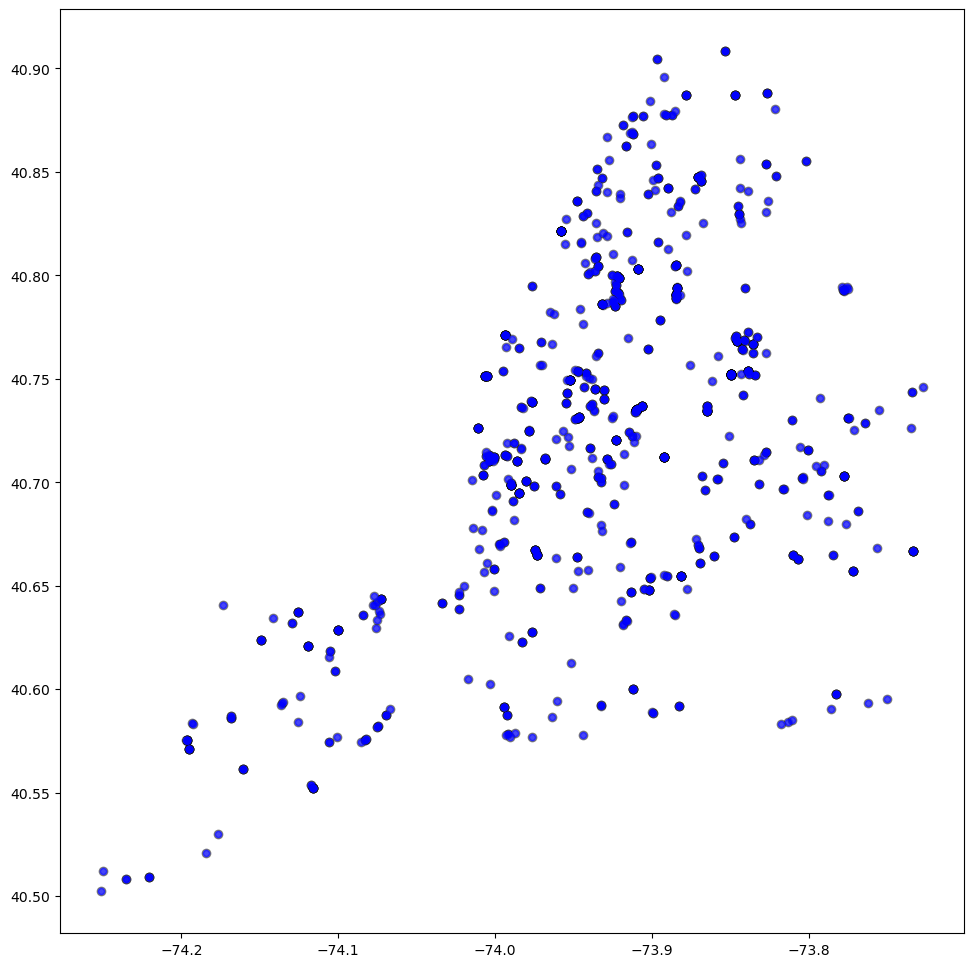

In [139]:
# Step 1: Convert hotspots_summary to GeoDataFrame
hotspots_gdf = gpd.GeoDataFrame(
    hotspots_summary,
    geometry=gpd.points_from_xy(hotspots_summary['longitude'], hotspots_summary['latitude']),
    crs="EPSG:4326"  # Set CRS to WGS84
)

# Step 2: Existing charging stations as GeoDataFrame
charging_stations_gdf = gpd.GeoDataFrame(
    cs,
    geometry=gpd.points_from_xy(cs['LONGITUDE'], cs['LATITUDE']),
    crs="EPSG:4326"
)

# Step 3: NYC zones are already in cy_nyc (assume EPSG:4326 for simplicity)
# Plot NYC zones
fig, ax = plt.subplots(figsize=(12, 12))
cs_nyc.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.5, label="NYC Zones")

# Step 4: Add charging stations to the map
charging_stations_gdf.plot(
    ax=ax, color="blue", markersize=20, label="Existing Charging Stations", alpha=0.7
)

# Step 5: Add hotspots with color based on decision
decision_colors = {
    "Expand station at": "orange",
    "Build new station near": "red",
    "Covered": "green"
}

for decision, color in decision_colors.items():
    hotspots_gdf[hotspots_gdf['decision'].str.contains(decision, na=False)].plot(
        ax=ax, color=color, markersize=50, label=f"Hotspot ({decision})", alpha=0.7
    )

# Step 6: Add legends and titles
plt.title("EV Charging Station Expansion/Placement Map", fontsize=16)
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()